# Installation

In [18]:
!pip install -q "openvino-dev>=2023.0.0"
!pip install -q "python-ffmpeg<=1.0.16" moviepy transformers onnx onnxruntime
!pip install -q -I "git+https://github.com/garywu007/pytube.git"
!pip install -q "optimum-intel[openvino,diffusers]" "ipywidgets"
!pip install -q "diffusers>=0.16.1" "transformers>=4.28.0"
!pip install -q "git+https://github.com/huggingface/optimum-intel.git" datasets gradio
#!pip install sounddevice

from IPython import display
display.clear_output()

In [5]:
from pathlib import Path

REPO_DIR = Path("whisper")
if not REPO_DIR.exists():
    !git clone https://github.com/openai/whisper.git -b v20230124
!cd whisper && pip install .

display.clear_output()

# Step 1: "Say it" with Whisper!
## Step 1.1: Setup

In [6]:
from collections import namedtuple
from functools import partial
from utils.whisper_OV_utils import *
from utils.whisper_preprocess_utils import *

In [16]:
#TBD - get audio input
#For now, please use pre-recorded audio files
audio_file = Path("mountain.wav")

In [17]:
#Download whisper base model
import whisper
model = whisper.load_model("base")
model.to("cpu")
model.eval()
pass
#Delete the model encoder and decoder
#to replace with OV versions
del model.decoder
del model.encoder

In [7]:
#Specify OpenVINO Core()
core = Core()

In [8]:
#Select your device
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [9]:
Parameter = namedtuple('Parameter', ['device'])
def parameters():
    return iter([Parameter(torch.device('cpu'))])

In [21]:
model.encoder = OpenVINOAudioEncoder(core, 'whisper_models/whisper_encoder.xml', device=device.value)
model.decoder = OpenVINOTextDecoder(core, 'whisper_models/whisper_decoder.xml', device=device.value)
model.decode = partial(decode, model)
model.parameters = parameters
model.logits = partial(logits, model)

## Step 1.2: Run the pipeline

In [22]:
audio = resample_wav(audio_file)

In [23]:
transcription = model.transcribe(audio, beam_size=5, best_of=5, task="translate")

In [24]:
srt_lines = prepare_srt(transcription)
# save transcription
with audio_file.with_suffix(".srt").open("w") as f:
    f.writelines(srt_lines)

In [25]:
widgets.Audio.from_file(audio_file, loop=False)

Audio(value=b'RIFF\x90\xac\x12\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x02\x00D\xac\x00\x00\x10\xb1\x02\x00\x04\x0…

In [26]:
transcribed_txt = "".join(srt_lines)
print(transcribed_txt)

1
00:00:00,000 --> 00:00:06,000
 a mountain landscape in an impressionist style.




# Step 2: "Refine it" with Llama 2.0/Dolly

In [28]:
prompt = "Write a prompt for an AI stable diffusion prompt, building on the phrase" + transcribed_txt
prompt

'Write a prompt for an AI stable diffusion prompt, building on the phrase1\n00:00:00,000 --> 00:00:06,000\n a mountain landscape in an impressionist style.\n\n'

## Llama 2.0 (WIP)

In [1]:
import time
from transformers import LlamaTokenizer
from optimum.intel.openvino import OVModelForCausalLM

2023-08-07 13:30:03.757106: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-07 13:30:03.758884: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 13:30:03.789294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 13:30:03.791080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 13:30:04.255019: W tensorflow/compiler/tf2t

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [2]:
from huggingface_hub import login
login()

In [ ]:
#from optimum.intel.openvino import OVModelForCausalLM
#Do not need to run this twice
#from pathlib import Path
#model_path = Path('./ir_model')

#ov_model = OVModelForCausalLM.from_pretrained('meta-llama/Llama-2-7b-hf',
#                                              compile=False,
#                                              export=True)
#ov_model.half()
#ov_model.save_pretrained(model_path)

In [10]:
model_path = Path('llama_ir_model/')

ov_model = OVModelForCausalLM.from_pretrained(model_path, compile=False, device=device.value)
    
ov_model.compile()

Compiling the model...
Set CACHE_DIR to llama_ir_model/model_cache


In [15]:
prompt="Using the phrase 'a mountain landscape in an impressionist style', write a prompt for a stable diffusion model."

In [16]:
tokenizer = LlamaTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')

inputs = tokenizer(prompt, return_tensors="pt")
start = time.perf_counter()
generate_ids = ov_model.generate(inputs.input_ids,
                                 max_length=128)
end = time.perf_counter()
print(" --- text decoding --- ")
output_text = tokenizer.batch_decode(generate_ids,
                                     skip_special_tokens=True,
                                     clean_up_tokenization_spaces=False)[0]
print(f"Generation took {end - start:.3f} s on {device.value}")
print(f"Response: {output_text}")

 --- text decoding --- 
Generation took 21.500 s on CPU
Response: Using the phrase 'a mountain landscape in an impressionist style', write a prompt for a stable diffusion model.
The prompt is a mountain landscape in an impressionist style.
The prompt is a mountain landscape in an impressionist style. The prompt is a mountain landscape in an impressionist style. The prompt is a mountain landscape in an impressionist style. The prompt is a mountain landscape in an impressionist style. The prompt is a mountain landscape in an impressionist style. The prompt is a mountain landscape in an impressionist style. The prompt is a mountain landscape in an impressionist style. The prompt is a mountain landscape in


## Dolly (WIP)

In [8]:
from pathlib import Path
from transformers import AutoTokenizer
from optimum.intel.openvino import OVModelForCausalLM

model_id = "databricks/dolly-v2-3b"
model_path = Path("dolly-v2-3b")

tokenizer = AutoTokenizer.from_pretrained(model_id)

current_device = device.value

if model_path.exists():
    ov_model = OVModelForCausalLM.from_pretrained(model_path, device=current_device)
else:
    ov_model = OVModelForCausalLM.from_pretrained(model_id, device=current_device, from_transformers=True)
    ov_model.save_pretrained(model_path)
display.clear_output()

The argument `from_transformers` is deprecated, and will be removed in optimum 2.0.  Use `export` instead
Framework not specified. Using pt to export to ONNX.
Using framework PyTorch: 1.13.1+cpu
Overriding 1 configuration item(s)
	- use_cache -> True
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode
In-place op on output of tensor.shape. See https://pytorch.org/docs/master/onnx.html#avoid-inplace-operations-when-using-tensor-shape-in-tracing-mode

# Step 3: "See it" with Stable Diffusion!

In [ ]:
from openvino.runtime import Core
from optimum.intel.openvino import OVStableDiffusionPipeline

ie = Core
#TBD = run only if model does not exist locally
# download the pre-converted SD v2.1 model from Hugging Face Hub
name = "helenai/stabilityai-stable-diffusion-2-1-base-ov"
pipe = OVStableDiffusionPipeline.from_pretrained(name, compile=False)
pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)
display.clear_output()

2023-08-07 13:51:41.362356: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-07 13:51:41.364063: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 13:51:41.394467: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 13:51:41.395993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 13:51:41.879342: W tensorflow/compiler/tf2t

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [ ]:
pipe.to("CPU")
pipe.compile()

In [5]:
#TBD - replace with outputs of Llama
refined_prompt = "a mountain landscape in an impressionist style, 4k, 8k"

  0%|          | 0/18 [00:00<?, ?it/s]

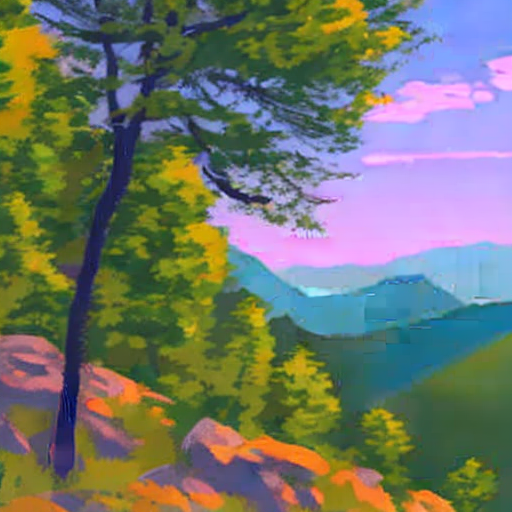

In [6]:
# Generate an image. 
#refined_prompt = "red car in snowy forest, epic vista, beautiful landscape, 4k, 8k"
output = pipe(refined_prompt, num_inference_steps=20, output_type="pil").images[0]
output.save("image.png")
output

# Step 4: "Understand it" with CLIP!